# BrainNetCNN 
version 1 <br>
Software by **Amine Echraibi**<br>
This notebook implements the method described [Here](http://www.sciencedirect.com/science/article/pii/S1053811916305237) and verifies the results. <br>
This is a re-implementation in Keras Tensorflow backend, of the neural net described in the paper.


In [1]:
from __future__ import print_function, division

import matplotlib.pyplot as plt
plt.interactive(False)
import tensorflow as tf
import h5py
from scipy.stats import pearsonr
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras import optimizers, callbacks, regularizers, initializers
from E2E_conv import *
from utils import *
from injury import ConnectomeInjury

Using TensorFlow backend.


Setting up the hyper parameters, and l2 regularizer




In [2]:
# Globals : Hyperparamaters
batch_size = 14
dropout = 0.5
momentum = 0.9
noise_weight = 0.125
lr = 0.01
decay = 0.0005

# Setting l2_norm regularizer
reg = regularizers.l2(decay)
kernel_init = initializers.he_uniform()

 ## Representation of syntheticly generated connectome
 ### Generating data
 

In [3]:
# Loading synthetic data
injuryconnectome = ConnectomeInjury()
x_train,y_train = injuryconnectome.generate_injury(n_samples=1000,noise_weight=noise_weight)
x_valid,y_valid = injuryconnectome.generate_injury(n_samples=300,noise_weight=noise_weight)


### ploting a synthetic connectome


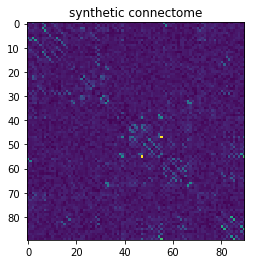

The adjacency matrix : 
[[ 0.09277971  0.05745714  0.2022883  ...,  0.08079796  0.01450556
   0.03400683]
 [ 0.05745714  0.07322132  0.04485602 ...,  0.08218496  0.0596679
   0.06026576]
 [ 0.2022883   0.04485602  0.06347865 ...,  0.06062021  0.0923228
   0.0723267 ]
 ..., 
 [ 0.08079796  0.08218496  0.06062021 ...,  0.05283508  0.04658768
   0.18001154]
 [ 0.01450556  0.0596679   0.0923228  ...,  0.04658768  0.08152442
   0.06694158]
 [ 0.03400683  0.06026576  0.0723267  ...,  0.18001154  0.06694158
   0.06580757]]


In [4]:
# ploting a sample
%matplotlib inline
plt.imshow(x_train[0][0])
plt.title('synthetic connectome')
plt.show()
print("The adjacency matrix : ")
print(x_train[0][0])


# reshaping data
x_train = x_train.reshape(x_train.shape[0],x_train.shape[3],x_train.shape[2],x_train.shape[1])
x_valid = x_valid.reshape(x_valid.shape[0],x_valid.shape[3],x_valid.shape[2],x_valid.shape[1])

the synthetic connectome is represented as a graph $G(A,\Omega)$ where : <br> 
- $\Omega$ is the set of nodes each node represents a region of the brain.
- $ A $ is the weighted adjency matrix of the adges representing the strength of the connections between the regions.

## Constructing the new layers
### E2E layer 
$$ A^{l+1,n}_{i,j} = \sum_{k=1}^{|\Omega|} \sum_{m=1}^{M^{l}}[ r_k^{l,m,n}A_{i,k}^{l,m} +   c_k^{l,m,n}A_{k,j}^{l,m}] $$
To construct this layer, we must create two kernels corresponding to r and c of size $1x|\Omega|$ and $|\Omega|x1$ respectively, we then convolve with the output filters, duplicate them $|\Omega|$ times than sum the duplications elementwize to create the convolution discribed above.

In [5]:
# Construction of the Edge-2-Edge layer using Keras backend.
# -*- coding: utf-8 -*-
from __future__ import absolute_import

from keras import backend as K
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.engine import Layer
from keras.engine import InputSpec
from keras.utils import conv_utils

class E2E_conv(Layer):
    def __init__(self, rank,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='valid',
                 data_format=None,
                 dilation_rate=1,
                 activation=None,
                 use_bias=False,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(E2E_conv, self).__init__(**kwargs)
        self.rank = rank
        self.filters = filters
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, rank, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, rank, 'dilation_rate')
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=self.rank + 2)

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        kernel_shape=K.get_value(self.kernel).shape
        d=kernel_shape[1]
        kernel1xd = K.reshape(self.kernel[0,:],(1,kernel_shape[1],kernel_shape[2],kernel_shape[3]))
        kerneldx1 = K.reshape(self.kernel[1,:], (kernel_shape[1],1, kernel_shape[2], kernel_shape[3]))
        conv1xd = K.conv2d(
            inputs,
            kernel1xd,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)
        convdx1 = K.conv2d(
                inputs,
                kerneldx1,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        concat1 = K.concatenate([convdx1]*d,axis=1)
        concat2 = K.concatenate([conv1xd]*d,axis=2)
        return concat1+concat2

    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[1],input_shape[2],self.filters)

    def get_config(self):
        config = {
            'rank': self.rank,
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(E2E_conv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### E2N layer 
$$a^{l+1,n}_i = \sum_{k=1}^{|\Omega|} \sum_{m=1}^{M^{l}}[ r_k^{l,m,n}A_{i,k}^{l,m} +   c_k^{l,m,n}A_{k,i}^{l,m}]$$
A simple 1-D convolution. Code in model architecture 

### E2N layer 
$$ a^{l+1,n} = \sum_{k=1}^{|\Omega|} \sum_{m=1}^{M^{l}} w_k^{l,m,n}a_{i}^{l,m}$$
A simple 1-D convolution. Code in model architecture 

## Creating the model
### Description :
![alt text](screen1.png "Description of the different layers")
l2_regularization was introduced in every layer. 
Dropout of 0.5 was introduced for every layer after N2G layer.
The Activation uses very leaky rectified linear units '$\alpha=0.33$'.


In [6]:
# Model architecture 

model = Sequential()
model.add(E2E_conv(2,32,(2,90),kernel_regularizer=reg,input_shape=(90,90,1),input_dtype='float32',data_format="channels_last"))
print("First layer output shape :"+str(model.output_shape))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(E2E_conv(2,32,(2,90),kernel_regularizer=reg,data_format="channels_last"))
print(model.output_shape)
model.add(LeakyReLU(alpha=0.33))
model.add(Convolution2D(64,(1,90),kernel_regularizer=reg,data_format="channels_last"))
model.add(LeakyReLU(alpha=0.33))
model.add(Convolution2D(256,(90,1),kernel_regularizer=reg,data_format="channels_last"))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(128,kernel_regularizer=reg,kernel_initializer=kernel_init))
#print(model.output_shape)
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(30,kernel_regularizer=reg,kernel_initializer=kernel_init))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(2,kernel_regularizer=reg,kernel_initializer=kernel_init))
model.add(Flatten())
model.add(LeakyReLU(alpha=0.33))
model.summary()
#print(model.output_shape)

First layer output shape :(None, 90, 90, 32)
(None, 90, 90, 32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e2e_conv_1 (E2E_conv)        (None, 90, 90, 32)        5760      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 90, 90, 32)        0         
_________________________________________________________________
e2e_conv_2 (E2E_conv)        (None, 90, 90, 32)        184320    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 1, 64)         184384    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 90, 1, 64)         0         
_________________________________________________________________
conv2d_2 (Co

## Training The model
- We use the euclidean distance as a cost function
- The evaluation metric is the mean absolute error

## Generating the results

In [10]:
from injury import ConnectomeInjury
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error as mae
from numpy import std
from IPython.display import HTML, display
import tabulate

def generate_synthetic_validation_data(noise):
    injury = ConnectomeInjury() # Generate train/test synthetic data.
    x_valid_y_valid = injury.generate_injury(n_samples=300, noise_weight=noise)
    return x_valid_y_valid


def get_results_from_models(model,noises):
    results = [["noises"]+noises,
               ["mae_alpha"],
               ["stdae_alpha"],
               ["mae_beta"],
               ["stdae_beta"],
               ["r_alpha"],
               ["r_beta"]]
    for i in range(len(noises)):
        noise = noises[i]
        x_valid, y_valid = generate_synthetic_validation_data(noise)
        x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[3], x_valid.shape[2], x_valid.shape[1])
        # load weights into new model
        model.load_weights("Weights/BrainCNNWeights_noise_"+str(noise)+".h5")
        print("Loaded model from disk")
        preds = model.predict(x_valid)
        results[1].append("{0:.2f}".format(100*mae(preds[:,0],y_valid[:,0])))
        results[2].append("{0:.2f}".format(100*std(abs(y_valid[:, 0] - preds[:, 0]))))
        results[3].append("{0:.2f}".format(100*mae(preds[:, 1], y_valid[:, 1])))
        results[4].append("{0:.2f}".format(100*std(abs(y_valid[:,1]-preds[:,1]))))
        results[5].append("{0:.2f}".format(pearsonr(preds[:,0],y_valid[:,0])[0]))
        results[6].append("{0:.2f}".format(pearsonr(preds[:, 1], y_valid[:, 1])[0]))
    display(HTML(tabulate.tabulate(results, tablefmt='html')))

## Main function
can be run in two modes the training mode where we train the model on the genrated data above (set the desired noise weight above), or the predicting mode where we run our generated trained model on different noise weights and display the results.

In [13]:
opt = optimizers.SGD(momentum=momentum,nesterov=True,lr=lr)
model.compile(optimizer=opt,loss='mean_squared_error',metrics=['mae'])
csv_logger = callbacks.CSVLogger('BrainCNN.log')
command = str(raw_input("Train or predict ? [t/p] "))
if command == "t":
    print("Training for noise = "+str(noise_weight))
    history=model.fit(x_train,y_train,nb_epoch=1000,verbose=1,callbacks=[csv_logger])
    model.save_weights("Weights/BrainCNNWeights_noise_"+str(noise_weight)+".h5")
else:
    print("[*] Predicting and printing results for the models trained :")
    get_results_from_models(model,noises = [0,0.0625,0.125,0.25])

Train or predict ? [t/p] p
[*] Predicting and printing results for the models trained :
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk


noises,0,0.0625,0.125,0.25
mae_alpha,3.27,6.17,10.69,15.46
stdae_alpha,2.41,4.3,8.37,11.8
mae_beta,2.17,5.74,9.36,16.26
stdae_beta,1.64,3.88,7.12,11.78
r_alpha,1,0.96,0.87,0.65
r_beta,1,0.97,0.89,0.66


the table above describes the results of the mean absolute error, standard deviation absolute error, and correlation for each of the parameters alpha and beta for different levels of noise.
#### Conclusion: the results mat